# Jena Climate Timeseries Data_Set(LSTM with GPU)
## Dropout
* 2009년부터 2016년까지의 독일 예나지역의 날씨정보 시계열 데이터
* 시계열 데이터를 사용하여 모델 생성 후 24시간 이후의 기온을 예측
* jena_climate_2009_2016.csv

## Import Tensorflow & Keras

* TensorFlow Version 지정

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

'1.15.0'

* GPU 설정 확인

In [0]:
print('GPU Information -', tf.test.gpu_device_name(), '\n')

!nvidia-smi

GPU Information - /device:GPU:0 

Sun Nov 24 10:35:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    56W / 149W |     69MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                          

* Keras Version 확인

In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

# I. Colab File Upload

> ## 1) 'jena_climate_2009_2016.csv' 파일을 Colab에 업로드 후 진행
* 약 4분

In [0]:
!ls

jena_climate_2009_2016.csv  sample_data


# II. Data Preprocessing

> ## 1) jena 기온 데이터
* Header 정보 확인
* 420551 x 15

In [0]:
fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines), len(header))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551 15


> ## 2) 날짜정보 제거
* 420551 x 14

In [0]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

float_data.shape

(420551, 14)

> ## 2) Train_Data Standardization
* 1번부터 200000번까지 표준화
* 평균(mean)을 빼고 표준편차(std)로 나누기

In [0]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean

std = float_data[:200000].std(axis = 0)
float_data /= std

# III. 시계열 데이터 처리 함수

> ## 1) generator( ) 함수 정의

* 시계열 데이터 : samples
* 타겟  데이터 : targets
* Tuple Return : (samples, targets)
 * data : 원본 배열
 * lookback : 과거로 이동할 타임스텝(1440 -> 10일)
 * delay : targets으로 사용할 미래의 타임스텝(144 -> 1일)
 * min_index & max_index : 추출할 타임스텝 범위지정
 * shuffle : 시계열 데이터를 시간순서대로 추출
 * batch_size : 배치 샘플 수
 * step : 샘플링할 타입스템 간격(6 -> 1시간)

In [0]:
def generator(data,
              lookback,
              delay,
              min_index, max_index,
              shuffle = False,
              batch_size = 128,
              step = 6):
  
    if max_index is None:
        max_index = len(data) - delay - 1

    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        
        targets = np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

> ## 2) generator( ) 함수 적용

* train_gen
* valid_gen
* test_gen

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128


train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step, 
                      batch_size = batch_size)

valid_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      step = step,
                      batch_size = batch_size)

test_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 300001,
                     max_index = None,
                     step = step,
                     batch_size = batch_size)



# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
valid_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# IV. LSTM with GPU Keras Modeling

> ## 1) Model Define

* Dropout

In [0]:
from keras import models,layers

model = models.Sequential()
model.add(layers.CuDNNLSTM(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

* Model Summary

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 32)                6144      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 6,177
Trainable params: 6,177
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Compile

In [0]:
model.compile(loss = 'mae',
              optimizer = 'rmsprop')

> ## 3) Model Fit
* 약 10분

In [0]:
Hist_gpu = model.fit_generator(train_gen,
                               steps_per_epoch = 500,
                               epochs = 20,
                               validation_data = valid_gen,
                               validation_steps = valid_steps)

> ## 4) 학습결과 시각화

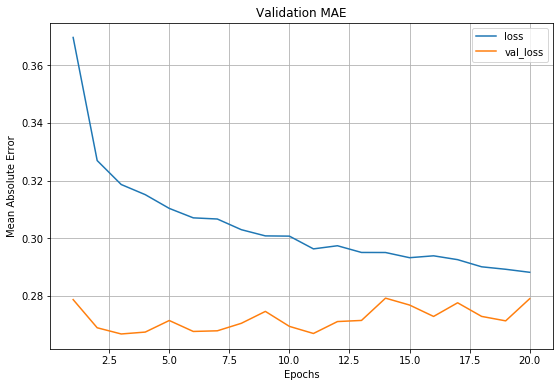

In [0]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_gpu.history['val_loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_gpu.history['loss'])
plt.plot(epochs, Hist_gpu.history['val_loss'])
plt.title('Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.legend(('loss', 'val_loss'))
plt.show()

> ## 5) Model Evaluate

In [0]:
mae = model.evaluate_generator(test_gen, steps = test_steps)

print('MAE = {:.5f}'.format(mae))

MAE = 0.28978


# V. Model Save & Load to Google Drive

> ## 1) Google Drive Mount

In [0]:
from google.colab import drive

drive.mount('/content/drive')

> ## 2) Model Save

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/models/jena_LSTM_GPU_Dropout.h5')

!ls /content/drive/My\ Drive/Colab\ Notebooks/models

> ## 3) Model Load

In [0]:
from keras.models import load_model

model = load_model('/content/drive/My Drive/Colab Notebooks/models/jena_LSTM_GPU_Dropout.h5')

# 
# 
# 
# The End
# 
# 
# 